In [1]:
import hnswlib
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import scipy.sparse
from modules import network,mlp
from utils import yaml_config_hook,save_model
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

In [2]:
parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [3]:
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\anndata\_core\anndata.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


(8569, 2000) (8569, 1)


,2,10,13,41,45,62,68,106,133,147,...,19763,19786,19808,19854,19883,20021,20073,20109,20121,20124
0,0.0,1.302199,0.0,0.0,0.0,0.000000,0.36896,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.637877,0.368960
1,0.0,1.351171,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.888292,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.711146,0.00000,0.0,0.0,0.0,...,0.0,0.417500,0.0,0.0,0.93785,0.0,0.0,0.0,0.937850,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.509045,0.00000,0.0,0.0,0.0,...,0.0,0.509045,0.0,0.0,0.00000,0.0,0.0,0.0,0.509045,0.509045


In [4]:
from torch.utils.data import DataLoader,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

# scTrainLength = int(len(scDataset) * 0.8)
# scValidLength = len(scDataset) - scTrainLength
# scTrain, scValid = random_split(scDataset, [scTrainLength, scValidLength])

scDataLoader = DataLoader(scDataset, shuffle=False, batch_size=args.batch_size,drop_last=True)
# scValidDataLoader = DataLoader(scValid, shuffle=True, batch_size=256,drop_last=True)

for features, labels in scDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

2000
1024
1024


In [5]:
mlpp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlpp, args.feature_dim, args.classnum)
model = model.to('cuda')

In [6]:
def findAllFile(base):
    for root, ds, fs in os.walk(base):
        for f in fs:
            yield f

In [16]:
index=np.where(y_ndarray.squeeze()==8)
x_8 =x_ndarray[index]
print(x_8.shape)

(18, 2000)


In [20]:
history_index_result=[]
for i in list(findAllFile('save\sc-static-bank')):
    checkpoint=torch.load('save\sc-static-bank\\'+i)
    model.load_state_dict(checkpoint['net'])
    x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
    embeddings=model.forward_embedding(x)
    embeddings=embeddings.detach().cpu().numpy()
    index=hnswlib.Index(space='cosine',dim=128)
    index.init_index(max_elements=len(embeddings), ef_construction=100, M=16)
    index.set_ef(100)
    index.set_num_threads(4)
    index.add_items(embeddings)
    x_8_nn=[]
    x_8_embeddings=model.forward_embedding(torch.tensor(x_8,dtype=torch.float32).to('cuda')).detach().cpu().numpy()
    for i in x_8_embeddings:
        label,distance=index.knn_query(i,k=10)
        x_8_nn.append(label.squeeze())
        # print(incorrect)
    history_index_result.append(x_8_nn)
    
print(np.array(history_index_result).shape)


(70, 18, 10)


In [26]:
import seaborn as sns
palette = sns.color_palette("tab20", args.classnum)

In [73]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['tab:blue','tab:red'])

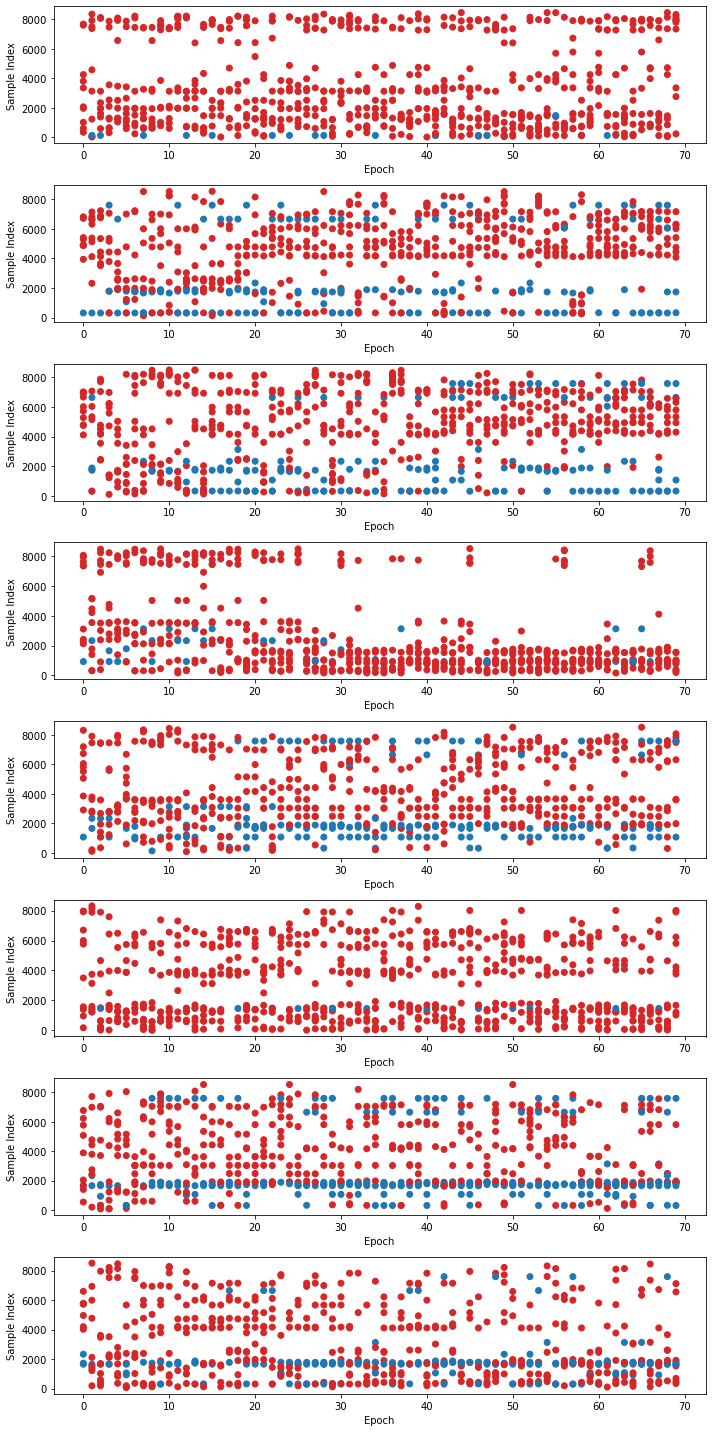

In [75]:
f, ax = plt.subplots(nrows=8, ncols=1, figsize=(10, 20))
for j in range(8):

    sample_0=[]
    correctness=[]
    for i in history_index_result:
        sample_0.append(i[j])
        for label in i[j]:
            if y_ndarray[label]==8:
                correctness.append(0)
            else:
                correctness.append(1)
    # print(np.array(sample_0).shape)
    x_index=np.arange(70)
    x_index=np.repeat(x_index,10)
    # print(x_index.shape)
    sample_0=np.array(sample_0).reshape(700,)
    # print(sample_0.shape)
    # print(np.array(correctness).shape)
    # plt.figure(figsize=(10, 2))
    ax[j].scatter(x_index, sample_0,c=correctness,cmap=cmap)
    ax[j].set_xlabel('Epoch')
    ax[j].set_ylabel('Sample Index')
    plt.tight_layout()